In [1]:
import pandas as pd
import string

import spacy
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
review_data= pd.read_csv("C:\\AmazonReviews\\Reviews.csv")
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
568454
Unique Products
74258
Unique Users
256059


***
Data Pre-Processing
***

In [3]:
def clean_text(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation}       # Replacing all punctuations with empty character
    delete_dict[' '] = ' '                                                        # Except for space (' ')
    table = str.maketrans(delete_dict)                                            # Making a transition table to apply the replacement in strings
    text1 = text.translate(table)                                                 # Translate text by removing the punctuations
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if (not w.isdigit() and len(w)>3)])
    
    return text2.lower()

In [4]:
review_data.dropna(axis = 0, how ='any',inplace=True)                             # Removes rows with null values from the dataset

review_data['Text'] = review_data['Text'].apply(clean_text)                       # Cleaning the dataframe
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split()))    # Finding number of words (in text) in each row

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]                                              # Finding short reviews
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)        # Sampling the dataframe

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

In [6]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [7]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

received shipment time soon left door first response surprised carrier even left smashed origional size whole caved opened three bags nothing bits crumbs chips tossed case wont buying lays
['shipment', 'time', 'door', 'first', 'response', 'surprised', 'carrier', 'origional', 'size', 'whole', 'caved', 'bag', 'crumb', 'chip', 'case']


In [8]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

***
Building the Model
***

In [9]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [10]:
lda_model.print_topics()

[(0,
  '0.065*"sugar" + 0.057*"water" + 0.036*"drink" + 0.034*"milk" + 0.033*"taste" + 0.029*"bottle" + 0.027*"sweet" + 0.025*"flavor" + 0.018*"syrup" + 0.017*"juice"'),
 (1,
  '0.038*"chocolate" + 0.034*"flavor" + 0.031*"good" + 0.023*"taste" + 0.020*"great" + 0.015*"butter" + 0.014*"peanut" + 0.014*"candy" + 0.012*"love" + 0.012*"little"'),
 (2,
  '0.054*"flavor" + 0.036*"good" + 0.025*"sauce" + 0.020*"great" + 0.019*"rice" + 0.019*"taste" + 0.019*"coconut" + 0.016*"cheese" + 0.015*"soup" + 0.014*"little"'),
 (3,
  '0.128*"chip" + 0.083*"salt" + 0.040*"potato" + 0.039*"honey" + 0.023*"pill" + 0.020*"salty" + 0.018*"vitamin" + 0.015*"banana" + 0.015*"corn" + 0.015*"bag"'),
 (4,
  '0.078*"food" + 0.027*"treat" + 0.021*"dog" + 0.016*"good" + 0.015*"cat" + 0.015*"time" + 0.013*"year" + 0.013*"great" + 0.011*"little" + 0.011*"small"'),
 (5,
  '0.083*"product" + 0.012*"quality" + 0.011*"delivery" + 0.010*"company" + 0.010*"thank" + 0.009*"price" + 0.009*"great" + 0.009*"can" + 0.009*"fanta

In [11]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\aksha\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.151810 -0.147330       1        1  15.411751
4      0.111496 -0.122431       2        1  14.901277
8      0.103533  0.091562       3        1  14.057961
1      0.133855  0.046367       4        1  14.018173
5      0.027518 -0.180340       5        1   8.953971
2      0.083548  0.119353       6        1   8.780332
0     -0.019239  0.112149       7        1   7.742908
6      0.015748  0.036454       8        1   7.523979
9     -0.234207  0.239141       9        1   5.117053
3     -0.374062 -0.194924      10        1   3.492593, topic_info=             Term          Freq         Total Category  logprob  loglift
1          coffee  29771.000000  29771.000000  Default  30.0000  30.0000
47           food  23306.000000  23306.000000  Default  29.0000  29.0000
11        product  30255.000000  30255.000000  Default  28.0000  28.0000
18           chip   8958.000000   8958.000000  Default  27.0000  27.0000
109        flavor  32563.000000  32563.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
384   alternative    844.610854   1921.152490  Topic10  -4.4154   2.5327
14            bag   1017.021267   5137.963780  Topic10  -4.2297   1.7347
398       healthy    602.186323   7481.702405  Topic10  -4.7537   0.8349
67        regular    546.599601   5312.228628  Topic10  -4.8506   1.0805
2334    nutrition    382.324878    924.868355  Topic10  -5.2080   2.4711

[536 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
971       2  0.999123       adult
1128      6  0.997916  affordable
1253      1  0.999203   afternoon
1583      5  0.704210     allergy
1583      9  0.295523     allergy
...     ...       ...         ...
2612     10  0.997863       yeast
448       4  0.999365      yogurt
437       4  0.597106       yummy
437       5  0.220131       yummy
437       6  0.182067       yummy

[788 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 9, 2, 6, 3, 1, 7, 10, 4])

In [12]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # Measure of how good the model is. Lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.857175639929471

Coherence Score:  0.42202439238061995


In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

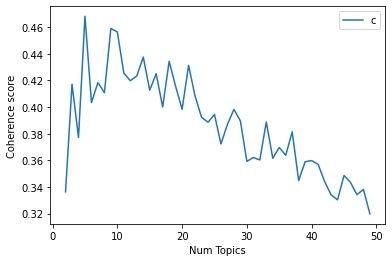

In [15]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3362
Num Topics = 3  has Coherence Value of 0.4172
Num Topics = 4  has Coherence Value of 0.3771
Num Topics = 5  has Coherence Value of 0.4682
Num Topics = 6  has Coherence Value of 0.4033
Num Topics = 7  has Coherence Value of 0.4184
Num Topics = 8  has Coherence Value of 0.4108
Num Topics = 9  has Coherence Value of 0.4591
Num Topics = 10  has Coherence Value of 0.4564
Num Topics = 11  has Coherence Value of 0.4255
Num Topics = 12  has Coherence Value of 0.4198
Num Topics = 13  has Coherence Value of 0.4233
Num Topics = 14  has Coherence Value of 0.4376
Num Topics = 15  has Coherence Value of 0.4127
Num Topics = 16  has Coherence Value of 0.425
Num Topics = 17  has Coherence Value of 0.4
Num Topics = 18  has Coherence Value of 0.4343
Num Topics = 19  has Coherence Value of 0.4155
Num Topics = 20  has Coherence Value of 0.3983
Num Topics = 21  has Coherence Value of 0.4313
Num Topics = 22  has Coherence Value of 0.4083
Num Topics = 23  has Cohe

In [17]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.035*"product" + 0.025*"price" + 0.025*"store" + 0.024*"amazon" + 0.021*"great" + 0.019*"good" + 0.017*"time" + 0.012*"year" + 0.011*"food" + 0.011*"order"'),
 (1,
  '0.031*"flavor" + 0.024*"taste" + 0.024*"good" + 0.020*"sugar" + 0.018*"water" + 0.016*"sweet" + 0.015*"great" + 0.014*"drink" + 0.013*"product" + 0.009*"coconut"'),
 (2,
  '0.029*"good" + 0.021*"flavor" + 0.020*"great" + 0.018*"chocolate" + 0.018*"chip" + 0.017*"cookie" + 0.016*"snack" + 0.016*"taste" + 0.011*"salt" + 0.011*"butter"'),
 (3,
  '0.089*"coffee" + 0.025*"good" + 0.025*"flavor" + 0.017*"strong" + 0.015*"taste" + 0.013*"great" + 0.011*"bean" + 0.010*"blend" + 0.009*"vanilla" + 0.009*"dark"'),
 (4,
  '0.051*"food" + 0.019*"treat" + 0.017*"dog" + 0.016*"good" + 0.013*"sauce" + 0.012*"great" + 0.011*"chicken" + 0.010*"little" + 0.009*"rice" + 0.009*"meal"')]

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\aksha\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.107964  0.202994       1        1  24.857194
1      0.101591 -0.125600       2        1  20.701329
2      0.027405 -0.055016       3        1  20.144744
4     -0.208927 -0.101779       4        1  17.588970
3      0.187894  0.079401       5        1  16.707763, topic_info=       Term          Freq         Total Category  logprob  loglift
23   coffee  29896.000000  29896.000000  Default  30.0000  30.0000
61     food  23460.000000  23460.000000  Default  29.0000  29.0000
19   amazon  12570.000000  12570.000000  Default  28.0000  28.0000
233  flavor  30955.000000  30955.000000  Default  27.0000  27.0000
58    store  13530.000000  13530.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
629    nice   2100.768868   8052.051988   Topic5  -5.0710   0.4457
127    milk   1871.167179   5997.648012   Topic5  -5.1868   0.6245
147    love   2076.813467  14946.346170   Topic5  -5.0825  -0.1843
322    time   1998.780722  17175.861177   Topic5  -5.1208  -0.3617
648  little   1896.255602  14352.743401   Topic5  -5.1734  -0.2348

[404 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3210      1  0.998958   addictive
2738      1  0.998472  affordable
200       1  0.087985     allergy
200       2  0.000765     allergy
200       3  0.019127     allergy
...     ...       ...         ...
3366      1  0.995445      yorkie
2502      1  0.060843       yummy
2502      3  0.789406       yummy
2502      4  0.065999       yummy
2502      5  0.083530       yummy

[891 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4])